In [51]:
from vedo import dataurl, Mesh, Plotter, Volume, settings, LinearTransform, Box, Line
import numpy as np
import pandas as pd
from normalize import normalize_shape,get_eigenvectors,get_center_of_mass
import os
from pathlib import Path
import matplotlib.pyplot as plt

"""
Input Mesh
Output one of Mixed,Quad,Triangle,Other (in case of non quad or triangle polygons)
"""

cellType = {
        3:"Triangle",
        4:"Quad"
    }
freq = {
        "Other":0,
        "Quad":0,
        "Triangle":0,
    }

def GetCellType(cells):
    for i in range(0,len(cells)):
        l = len(cells[i])
        #print(l,cellType[l])
        if(l in cellType):
            option = cellType[l]
        else:
            option = "Other"
        #print(option)
        val = freq.get(option)
        freq.update({option:val+1})

    if(freq["Other"])>0:
        return "Other"
    elif(freq["Quad"])==0:
        return "Triangle"
    elif(freq["Triangle"])==0:
        return "Quad"
    else:
        return "Mixed"
    
def get_vertex_dist(mesh:Mesh):
    #As the ratio of the smallest cell against largest cell
    minar = np.inf
    maxar = 0
    for idx in range(0,len(mesh.vertices)):
        ar = 0
        for cp in mesh.connected_vertices(idx):
            ar+= np.abs(np.linalg.norm(mesh.vertices[idx] - mesh.vertices[cp]))
        

        if ar!=0 and ar<minar:
            minar=ar
        elif ar!=0 and ar>maxar:
            maxar=ar
        #print(ar,minar,maxar)

    return maxar/minar

Step 2.1: Analyzing a single shape

Start building a simple tool that checks all shapes in the database. The tool should output, for each shape

    the class of the shape
    the number of faces and vertices of the shape
    the type of faces (e.g. only triangles, only quads, mixes of triangles and quads)
    the axis-aligned 3D bounding box of the shapes 

In [53]:
"""
Input: (Optional) Path of database, limit
Output: Pandas Dataframe with metainformation about each object, size limit. If no limit is set, the entire database is read

The following properties are computed
    the class of the shape
    the number of faces 
    number of vertices of the shape
    the type of faces (e.g. only triangles, only quads, mixes of triangles and quads)
    the axis-aligned 3D bounding box of the shapes 
    Additionally, average size, diagonal size, position, center of mass and scaling are retrieved
"""


def RetrieveShapeMeta(rootdir = "../shapes",limit=None,filename="metadata.csv"):
    paths = []
    vertices = []
    com = []
    means = []
    scalings = []
    s_average = []
    s_diagonal = []
    bounds = []
    positions = []
    cls = []
    cells = []
    types = []
    eigenvals = []
    eigenvecs = []
    vecdist = []
    i = 0 
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if(file.endswith(".obj")):
                if(limit!=None and i>limit):
                    break
                className = subdir.split("\\")[-1]
                path = os.path.join(subdir, file)
                print(f"Reading {path}")
                paths.append(path)
                mesh = Mesh(path)
                vertices.append(len(mesh.vertices))
                com.append(mesh.center_of_mass())
                means.append(np.mean(mesh.vertices,axis=0))
                scalings.append( mesh.scale())
                s_average.append(mesh.average_size())
                s_diagonal.append(mesh.diagonal_size())
                positions.append(mesh.pos())
                bounds.append(mesh.bounds())
                cells.append(mesh.ncells)
                vecdist.append(get_vertex_dist(mesh))
                cls.append(className)
                faceType = GetCellType(mesh.cells)
                types.append(faceType)
                eigenval,eigenvec = get_eigenvectors(mesh)
                eigenvals.append(eigenval)
                eigenvecs.append(eigenvec)
                i+=1

    df = pd.DataFrame({"Path":paths,
                        "Vertices":vertices,
                        "CenterOfMass":com,
                        "Means":means,
                        "Scaling":scalings,
                        "AverageSize":s_average,
                        "DiagonalSize":s_diagonal,
                        "Bounds":bounds,
                        "Position":positions,
                        "Cells":cells,
                        "Class":cls,
                        "Type":types,
                        "Eigenvalue":eigenvals,
                        "Eigenvectors":eigenvecs,
                        "Distribution":vecdist})
    df.to_csv(filename)
    return df



df = RetrieveShapeMeta(limit=None,filename="metadata.csv")
#df = pd.read_csv("metadata.csv")
print(df)

Reading ../shapes\AircraftBuoyant\m1337.obj
[[ 1.37933137e-03 -8.60535996e-01  5.09387767e-01]
 [-9.99998671e-01 -1.62949098e-03 -4.49679127e-05]
 [-8.68739279e-04  5.09387028e-01  8.60537100e-01]] [0.10504596 0.04645249 0.04645206]
Reading ../shapes\AircraftBuoyant\m1338.obj
[[ 1.08941545e-03 -9.99859181e-01  1.67460613e-02]
 [-9.99999204e-01 -1.09992458e-03 -6.18360358e-04]
 [-6.36692685e-04  1.67453743e-02  9.99859584e-01]] [0.09733962 0.04685405 0.04683994]
Reading ../shapes\AircraftBuoyant\m1339.obj
[[ 0.00532142  0.9999363   0.00995386]
 [ 0.99998422 -0.00533906  0.00174674]
 [-0.00179977 -0.0099444   0.99994893]] [0.06554274 0.00866799 0.00892623]
Reading ../shapes\AircraftBuoyant\m1340.obj
[[ 0.00116887  0.99997913 -0.00635391]
 [ 0.99999145 -0.00119405 -0.00395971]
 [ 0.00396722  0.00634922  0.99997197]] [0.08524597 0.00322742 0.00317761]
Reading ../shapes\AircraftBuoyant\m1341.obj
[[-2.07843352e-04 -9.99999978e-01  1.48961295e-06]
 [-9.99999978e-01  2.07843352e-04 -1.29210812

Step 2.2: Statistics over the whole database

Use the output of the tool, e.g. saved in an Excel sheeet or CSV file, to find out 
(a) what is the average shape in the database (in terms of vertex and face counts); and 
(b) if there are significant outliers from this average (e.g. shapes having many, or few, vertices or cells). The best way to do this is to show a histogram counting how many shapes are in the database for every range of the property of interest (e.g., number of vertices, number of faces, shape class).

Use the viewer constructed in step 1 to show an average shape and a few such outliers (if any). 

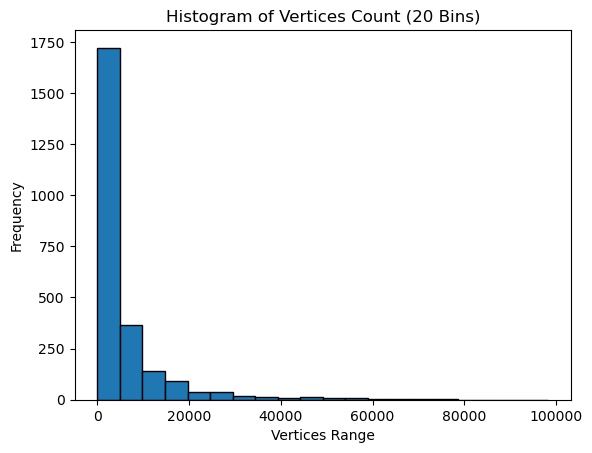

Mean Vertex Count: 5609.783326621023
Standard Deviation Vertex Count: 9849.175641551707
Max Vertex Count: 98256-../shapes\PlantIndoors\D00159.obj
Min Vertex Count: 16-../shapes\Door\D01121.obj


In [4]:
#VERTICES STATISTICS

plt.hist(df['Vertices'], bins=20, edgecolor='black')

# Adding labels and title
plt.xlabel('Vertices Range')
plt.ylabel('Frequency')
plt.title('Histogram of Vertices Count (20 Bins)')

# Display the histogram
plt.show()

#Get Outliers
maxind = np.argmax(df['Vertices'])
minind = np.argmin(df['Vertices'])

print(f"Mean Vertex Count: {np.mean(df['Vertices'])}")
print(f"Standard Deviation Vertex Count: {np.std(df['Vertices'])}")
print(f"Max Vertex Count: {np.max(df['Vertices'])}-{df.loc[maxind]['Path']}")
print(f"Min Vertex Count: {np.min(df['Vertices'])}-{df.loc[minind]['Path']}")

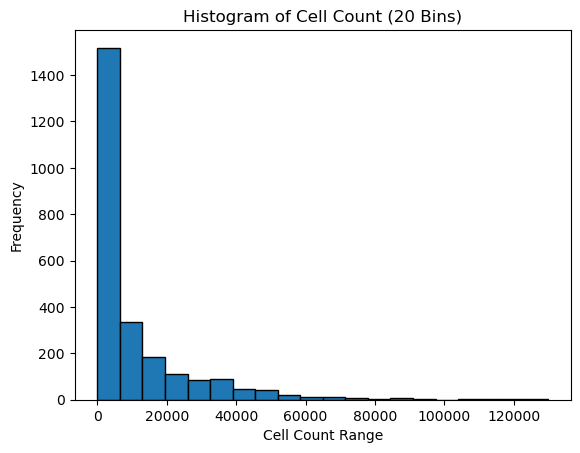

Mean Cell Count: 10691.52597664116
Standard Deviation Cell Count: 16187.973461611178
Max Cell Count: 129881-../shapes\Biplane\m1120.obj
Min Cell Count: 16-../shapes\Door\D01121.obj


In [73]:
#EDGE STATISTICS

plt.hist(df['Cells'], bins=20, edgecolor='black')

# Adding labels and title
plt.xlabel('Cell Count Range')
plt.ylabel('Frequency')
plt.title('Histogram of Cell Count (20 Bins)')

# Display the histogram
plt.show()

#Get Outliers
maxind = np.argmax(df['Cells'])
minind = np.argmin(df['Cells'])

print(f"Mean Cell Count: {np.mean(df['Cells'])}")
print(f"Standard Deviation Cell Count: {np.std(df['Cells'])}")
print(f"Max Cell Count: {np.max(df['Cells'])}-{df.loc[maxind]['Path']}")
print(f"Min Cell Count: {np.min(df['Cells'])}-{df.loc[minind]['Path']}")


In [75]:
distances = euclidean_distances(df["CenterOfMass"], df["Position"])

ind = np.argmax(distances)
print(ind,df.loc[ind])

1846 Path                                  ../shapes\Quadruped\m94.obj
Vertices                                                     3332
CenterOfMass    [8680047.383141086, -74626711.25540216, -14701...
Means                      [8680054.0, -74626610.0, -147016560.0]
Scaling                                           [1.0, 1.0, 1.0]
AverageSize                                           142400528.0
DiagonalSize                                      510259692.38123
Bounds          [-39746300.0, 55866200.0, -172210000.0, 210990...
Position                                          [0.0, 0.0, 0.0]
Cells                                                        6328
Class                                                   Quadruped
Type                                                     Triangle
Name: 1846, dtype: object


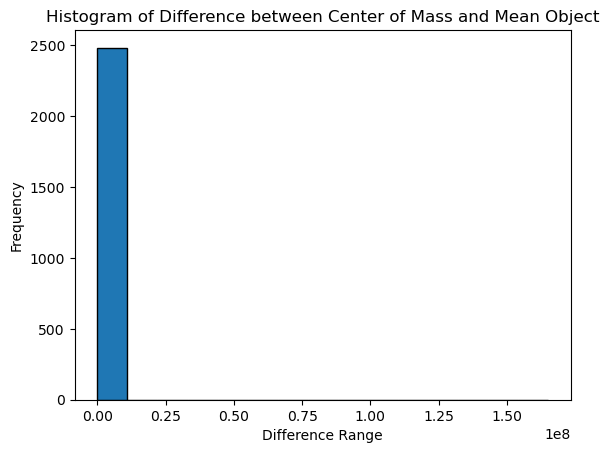

In [76]:
plt.hist(distances, bins=15, edgecolor='black')

# Adding labels and title
plt.xlabel('Difference Range')
plt.ylabel('Frequency')
plt.title('Histogram of Difference between Center of Mass and Mean Object')

# Display the histogram
plt.show()

In [7]:
df["Type"].unique()

array(['Triangle'], dtype=object)

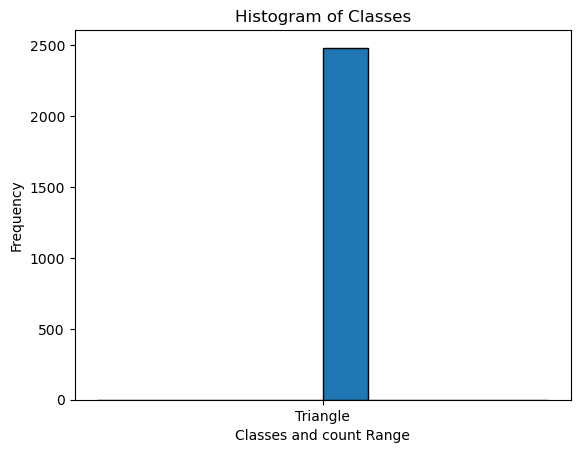

In [12]:
#Investigating Classes
plt.hist(df['Type'], edgecolor='black')

# Adding labels and title
plt.xlabel('Classes and count Range')
plt.ylabel('Frequency')
plt.title('Histogram of Classes')

# Display the histogram
plt.show()


In [78]:
settings.default_backend = 'k3d'
filepath = "..\shapes\AircraftBuoyant\m1338.obj"
filepath2 = "..\shapes\AircraftBuoyant\m1338.obj"

mesh = Mesh(filepath).c("violet").flat()
mesh2 = Mesh(filepath2).c("green").flat()

# Set the backcolor of the mesh to violet
# and show edges with a linewidth of 2
mesh.backcolor('violet').linecolor('tomato').linewidth(2)
mesh.transform.set_position(mesh.pos()+[5,5,5])
print(mesh)

mesh2.transform.set_position(mesh2.pos()-mesh2.center_of_mass())
print(mesh2)
plot = Plotter(bg='black')
plot.show(mesh,mesh2)

vedo.mesh.Mesh at (0x173dba6ef70)                                          
name          : Mesh
file name     : ..\shapes\AircraftBuoyant\m1338.obj
color         : violet, rgb=(0.933, 0.510, 0.933), alpha=1.0
backface color: violet, rgb=(0.933, 0.510, 0.933)
elements      : vertices=8,761 polygons=16,960 lines=0
position      : (5.00000, 5.00000, 5.00000)
scaling       : (1.00000, 1.00000, 1.00000)
size          : average=0.435180, diagonal=1.60014
center of mass: (0.479911, 0.549835, 0.480937)
bounds        : x=(0.0250, 0.933), y=(0.0250, 0.975), z=(0.0250, 0.938)
pointdata     : "Normals" (float32), dim=3
celldata      : "GroupIds" (float32), dim=1, range=(0, 0)
vedo.mesh.Mesh at (0x173dba6c770)                                          
name          : Mesh
file name     : ..\shapes\AircraftBuoyant\m1338.obj
color         : green, rgb=(0.0157, 0.498, 0.0627), alpha=1.0
elements      : vertices=8,761 polygons=16,960 lines=0
position      : (-0.479911, -0.549835, -0.480937)
scaling   

Plot(antialias=True, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], camera_…

NORMALISATION STEPS

position: d(ci>0)~0
pose: eigenvectors * axis = 1 (for x,y,z axis)
remeshing: Check that target value for vertices is met. Histogram ||Vi|-T|| ~ 0 (satisfied in most condition)  
flip vector = ([1,0,0][0,1,0],[0,0,1])
size - largest bounding box axis = 1 

GLOBAL DESCRIPTORS
HISTOGRAMS
Comparing Histograms (for comparing different features) - Histogram of feature becomes a point
Area normalisation (Euclidian distance) - 
Angle normalisation for Histograms.  Distance = cosine similarity

cumulative histogram (more robust with respect to outliers) (con: unintuitive, technical instrument to remove noise)
Limitations of histograms for 3D descriptors: 

CALCULATING EDGES
First derivative large (i.e rapid change from dark to light)
Laplacian is close to 0 -> Sum of second derivatives (with respect to x, y ,z ) is close to 0 -> Point where accelleration turns into 0, Curvature concave turns into convex.





In [3]:
def euclidean_distances(list1, list2=None):
    distances = []
    if(list2==None):
        matrix = np.array([list(map(float, x.replace('[', '').replace(']', '').split())) for x in list1])
        distances = np.linalg.norm(matrix,axis=1)
    else:
        for point1, point2 in zip(list1, list2):
            # Convert points to NumPy arrays for easier calculations
            p1 = np.array(point1)
            p2 = np.array(point2)
            # Calculate Euclidean distance
            distance = np.linalg.norm(p1 - p2)
            distances.append(distance)
    
    return distances


In [3]:


def NormalizeShapes(rootdir = "../shapes",targetdir="../normshapes",limit=None,filename="metadata.csv"):
    orig_paths = []
    vertices = []
    com = []
    means = []
    scalings = []
    s_average = []
    s_diagonal = []
    bounds = []
    positions = []
    cls = []
    cells = []
    types = []
    new_paths = []
    eigenvals = []
    eigenvecs = []
    peigenvals = []
    peigenvecs = []
    i = 0 
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if(file.endswith(".obj")):
                if(limit!=None and i>limit):
                    break
                className = subdir.split("\\")[-1]
                path = os.path.join(subdir, file)
                subpath = os.path.join(targetdir,className)
                Path(subpath).mkdir(parents=True, exist_ok=True)
                npath = os.path.join(targetdir,className,file)
                print(f"Reading {path}")
                orig_paths.append(path)
                new_paths.append(npath)
                mesh = Mesh(path)
                peigenvec,peigenval = get_eigenvectors(mesh)
                mesh = normalize_shape(mesh)
                eigenvec,eigenval = get_eigenvectors(mesh)
                vertices.append(len(mesh.vertices))
                com.append(mesh.center_of_mass())
                means.append(get_center_of_mass(mesh))
                scalings.append( mesh.scale())
                s_average.append(mesh.average_size())
                s_diagonal.append(mesh.diagonal_size())
                positions.append(mesh.pos())
                bounds.append(mesh.bounds())
                cells.append(mesh.ncells)
                cls.append(className)
                faceType = GetCellType(mesh.cells)
                types.append(faceType)
                peigenvals.append(peigenval)
                peigenvecs.append(peigenvec)
                eigenvals.append(eigenval)
                eigenvecs.append(eigenvec)
                mesh.write(npath)
                i+=1

    df = pd.DataFrame({ "New Path": new_paths,
                        "Orig Path":orig_paths,
                        "Vertices":vertices,
                        "CenterOfMass":com,
                        "Means":means,
                        "Scaling":scalings,
                        "AverageSize":s_average,
                        "DiagonalSize":s_diagonal,
                        "Bounds":bounds,
                        "Position":positions,
                        "Cells":cells,
                        "Class":cls,
                        "Type":types,
                        "Eigenvalue":eigenvals,
                        "Eigenvectors":eigenvecs,
                        "Prev Eigenvalue": peigenvals,
                        "Prev Eigenvectors":peigenvecs})
    df.to_csv(filename)
    return df



df = NormalizeShapes(limit=None,filename="normCorrMetadata.csv")
print(df)

Reading ../shapes\AircraftBuoyant\m1337.obj
Reading ../shapes\AircraftBuoyant\m1338.obj
Reading ../shapes\AircraftBuoyant\m1339.obj
Reading ../shapes\AircraftBuoyant\m1340.obj
Reading ../shapes\AircraftBuoyant\m1341.obj
Reading ../shapes\AircraftBuoyant\m1342.obj
Reading ../shapes\AircraftBuoyant\m1343.obj
Reading ../shapes\AircraftBuoyant\m1344.obj
Reading ../shapes\AircraftBuoyant\m1345.obj
Reading ../shapes\AircraftBuoyant\m1346.obj
Reading ../shapes\AircraftBuoyant\m1347.obj
Reading ../shapes\AircraftBuoyant\m1348.obj
Reading ../shapes\AircraftBuoyant\m1349.obj
Reading ../shapes\AircraftBuoyant\m1350.obj
Reading ../shapes\AircraftBuoyant\m1351.obj
Reading ../shapes\AircraftBuoyant\m1352.obj
Reading ../shapes\Apartment\D00045.obj
Reading ../shapes\Apartment\D00086.obj
Reading ../shapes\Apartment\D00138.obj
Reading ../shapes\Apartment\D00156.obj
Reading ../shapes\Apartment\D00310.obj
Reading ../shapes\Apartment\D00348.obj
Reading ../shapes\Apartment\D00366.obj
Reading ../shapes\Apart

<h1>Data Analysis (pre vs post normalisation)</h1>

In [31]:
origDF = pd.read_csv("metadata.csv")
normDF = pd.read_csv("normMetadata.csv")

In [35]:
origDF["Eigenvalue"] = normDF["Prev Eigenvalue"]
origDF["Eigenvectors"] = normDF["Prev Eigenvectors"]

<h2>Object Position</h2>

3.718003000683693


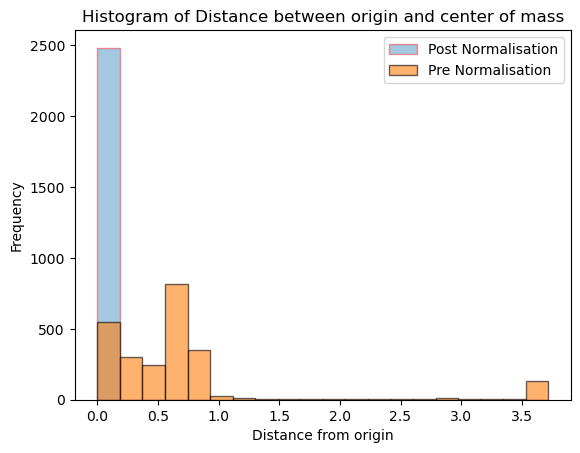

Mean of Distances (Original, Normalized): 66520.2157115397 - 0.000674911507704958
Median Distances (Original, Normalized): 0.5879852584821859 - 3.036847997572307e-09
Sum of Distances (Original, Normalized): 165169695.61175308 - 1.6758052736314106
SD of Distances (Original, Normalized): 3312638.2281475957 - 0.03361789817644376
Max of Distances (Original, Normalized): 165101074.91766515 - 1.675507655681969 - ../shapes\Quadruped\m94.obj - ../normshapes\Quadruped\m94.obj


In [50]:

origDist = euclidean_distances(origDF["CenterOfMass"])
normDist = euclidean_distances(normDF["CenterOfMass"])

quantile = np.quantile(origDist,0.95)
print(quantile)
#Get Outliers
maxindOrig = np.argmax(origDist)
maxindNorm = np.argmax(normDist)

plt.hist(np.clip(normDist, 0, quantile), bins=20, edgecolor='red',alpha=0.4,label='Post Normalisation',range=[0, quantile])
plt.hist(np.clip(origDist, 0, quantile), bins=20, edgecolor='black',alpha=0.6,label='Pre Normalisation', range=[0, quantile])
plt.legend()

# Adding labels and title
plt.xlabel('Distance from origin')
plt.ylabel('Frequency')
plt.title('Histogram of Distance between origin and center of mass')

# Display the histogram
plt.show()


print(f"Mean of Distances (Original, Normalized): {np.mean(origDist)} - {np.mean(normDist)}")
print(f"Median Distances (Original, Normalized): {np.median(origDist)} - {np.median(normDist)}")

print(f"Sum of Distances (Original, Normalized): {np.sum(origDist)} - {np.sum(normDist)}")
print(f"SD of Distances (Original, Normalized): {np.std(origDist)} - {np.std(normDist)}")
print(f"Max of Distances (Original, Normalized): {np.max(origDist)} - {np.max(normDist)} - {origDF.iloc[maxindOrig]['Path']} - {normDF.iloc[maxindNorm]['New Path']}")


<h2>Angle Sum </h2>
<p>Two paralell vectors will have a cross-product of 1. If all three eigenvectors are paralell with the unit axis, this custom measure is 0. The highest possible value is 3, (all eigenvectors are orthogonal to the unit-axis) This is the case for objects that are aligned along the "wrong" axis, values between 0 and 3 indicate that the objects are not aligned along one or more axis.</p>

In [44]:
def getAngleSum(eigenvalues,eigenvectors):
    if(pd.isna(eigenvalues) or pd.isna(eigenvectors)):
        return np.inf
    #np.array([list(map(float, x.replace('[', '').replace(']', '').split())) for x in list1])
    eigenvectors =[list(map(float,x)) 
                   for x in map(lambda x: x.split(),
                                filter(None,
                                       [x.replace('[', '').replace(']', '').strip() 
                                        for x in eigenvectors.split("]")]))]
    
    eigenvalues = list(map(float,eigenvalues.replace('[', '').replace(']', '').split()))
    
    #print(eigenvalues,eigenvectors)
    ranking = np.argpartition(eigenvalues, 2)
    x_align = np.abs(np.dot(eigenvectors[ranking[2]],[1,0,0]))
    y_align = np.abs(np.dot(eigenvectors[ranking[1]],[0,1,0]))
    z_align =np.abs(np.dot(eigenvectors[ranking[0]],[0,0,1]))
    #print("Values:",x_align,y_align,z_align)
    return 3-x_align-y_align-z_align

def getAngleSums(df):
    res = []
    for i in range(0,len(df)):
        v = getAngleSum(df["Eigenvalue"][i],df["Eigenvectors"][i])
        res.append(v)
    return res



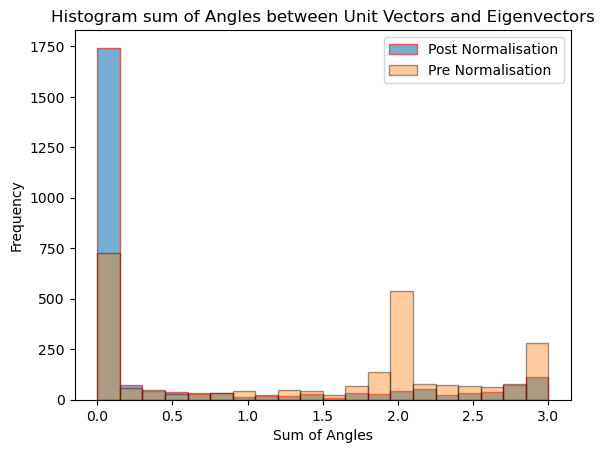

Mean of Distances (Original, Normalized): 1.4117532815601375 - 0.5237609260199905
Median Distances (Original, Normalized): 1.9024186299999999 - 0.002713531000000269
Sum of Distances (Original, Normalized): 3505.3833981138214 - 1300.4983793076362
SD of Distances (Original, Normalized): 1.0837356047841786 - 0.954082797225569
Max of Distances (Original, Normalized): 2.99999999425035 - 2.999677089282259 - ../shapes\BuildingNonResidential\m414.obj, ../normshapes\RectangleTable\m876.obj
Max of Distances (Original, Normalized): 2.99999999425035 - 2.999677089282259 - ../shapes\BuildingNonResidential\m414.obj, ../normshapes\RectangleTable\m876.obj


In [45]:
origDist = getAngleSums(origDF)
normDist = getAngleSums(normDF)

#Get Outliers
maxindOrig = np.argmax(origDist)
minindOrig = np.argmin(origDist)
maxindNorm = np.argmax(normDist)
minindNorm = np.argmin(normDist)

plt.hist(np.clip(normDist, 0, 3), bins=20, edgecolor='red',alpha=0.6,label='Post Normalisation',range=[0, 3])
plt.hist(np.clip(origDist, 0, 3), bins=20, edgecolor='black',alpha=0.4,label='Pre Normalisation', range=[0, 3])
plt.legend()

# Adding labels and title
plt.xlabel('Sum of Angles')
plt.ylabel('Frequency')
plt.title('Histogram sum of Angles between Unit Vectors and Eigenvectors')

# Display the histogram
plt.show()


print(f"Mean of Distances (Original, Normalized): {np.mean(origDist)} - {np.mean(normDist)}")
print(f"Median Distances (Original, Normalized): {np.median(origDist)} - {np.median(normDist)}")

print(f"Sum of Distances (Original, Normalized): {np.sum(origDist)} - {np.sum(normDist)}")
print(f"SD of Distances (Original, Normalized): {np.std(origDist)} - {np.std(normDist)}")
print(f"Max of Distances (Original, Normalized): {np.max(origDist)} - {np.max(normDist)} - {origDF.iloc[maxindOrig]['Path']}, {normDF.iloc[maxindNorm]['New Path']}")
print(f"Max of Distances (Original, Normalized): {np.max(origDist)} - {np.max(normDist)} - {origDF.iloc[maxindOrig]['Path']}, {normDF.iloc[maxindNorm]['New Path']}")

<h2>Object Size</h2>

In [25]:
def get_sizes(sizel):
    res = []
    for item in sizel["Bounds"]:
        #print(item)
        res.append(get_size(item))
    return res
def get_size(bbox_str):
    bbox_str =bbox_str.replace("[","").replace("]","").strip().split()
    bbox_l = list(map(float,bbox_str))
    
    Dx = np.abs(bbox_l[0] - bbox_l[1])  
    Dy = np.abs(bbox_l[2] - bbox_l[3])  
    Dz = np.abs(bbox_l[4] - bbox_l[5])  
    
    Dmax = max(Dx, Dy, Dz) #   # largest dimension of bounding box
    
    return Dmax

print(Mesh(origDF.iloc[0]["Path"]))
origDist = get_sizes(origDF)


vedo.mesh.Mesh at (0x1ff11aeed30)                                          
name          : Mesh
file name     : ../shapes\AircraftBuoyant\m1337.obj
elements      : vertices=201 polygons=340 lines=0
position      : (0, 0, 0)
scaling       : (1.00000, 1.00000, 1.00000)
size          : average=0.440347, diagonal=1.54800
center of mass: (0.458064, 0.515897, 0.456610)
bounds        : x=(0.0250, 0.889), y=(0.0250, 0.975), z=(0.0250, 0.889)
pointdata     : "Normals" (float32), dim=3
celldata      : "GroupIds" (float32), dim=1, range=(0, 0)


4.455942200000011


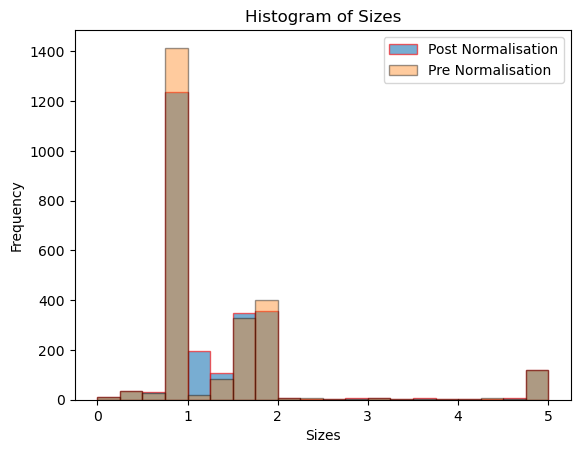

Mean of Sizes (Original, Normalized): 186276.29881259202 - 170263.55279887936
Median Sizes (Original, Normalized): 0.95 - 0.9750523
SD of Sizes (Original, Normalized): 9278625.937152708 - 8480841.18617293
Max of Sizes (Original, Normalized): 462444400.0 - 422683010.0 - ../shapes\Quadruped\m94.obj, ../normshapes\Quadruped\m94.obj
Min of Sizes (Original, Normalized): 0.067275 - 0.0664446876 - ../shapes\Spoon\D00422.obj, ../normshapes\Spoon\D00422.obj


In [29]:
origDist = get_sizes(origDF)
normDist = get_sizes(normDF)
print(np.quantile(origDist,0.95))
#Get Outliers
maxindOrig = np.argmax(origDist)
minindOrig = np.argmin(origDist)
maxindNorm = np.argmax(normDist)
minindNorm = np.argmin(normDist)

plt.hist(np.clip(normDist, 0, 5), bins=20, edgecolor='red',alpha=0.6,label='Post Normalisation',range=[0, 5])
plt.hist(np.clip(origDist, 0, 5), bins=20, edgecolor='black',alpha=0.4,label='Pre Normalisation', range=[0, 5])
plt.legend()

# Adding labels and title
plt.xlabel('Sizes')
plt.ylabel('Frequency')
plt.title('Histogram of Sizes')

# Display the histogram
plt.show()


print(f"Mean of Sizes (Original, Normalized): {np.mean(origDist)} - {np.mean(normDist)}")
print(f"Median Sizes (Original, Normalized): {np.median(origDist)} - {np.median(normDist)}")

print(f"SD of Sizes (Original, Normalized): {np.std(origDist)} - {np.std(normDist)}")
print(f"Max of Sizes (Original, Normalized): {np.max(origDist)} - {np.max(normDist)} - {origDF.iloc[maxindOrig]['Path']}, {normDF.iloc[maxindNorm]['New Path']}")
print(f"Min of Sizes (Original, Normalized): {np.min(origDist)} - {np.min(normDist)} - {origDF.iloc[minindOrig]['Path']}, {normDF.iloc[minindNorm]['New Path']}")

<h2>Vertex Normalisation</h2>
1) Check Vertex Count <br>
2) Check Vertex Distribution

23843.300000000014


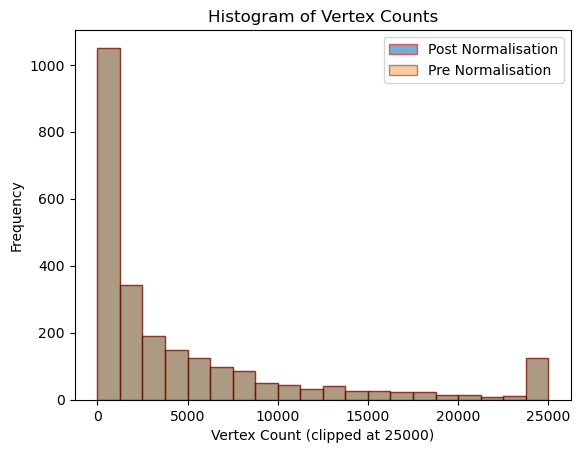

Mean # of vertices (Original, Normalized): 5609.783326621023 - 5609.783326621023
Median # of vertices (Original, Normalized): 1826.0 - 1826.0
SD of #of vertices (Original, Normalized): 9849.175641551707 - 9849.175641551707
Max of # of vertices (Original, Normalized): 98256 - 98256 - ../shapes\PlantIndoors\D00159.obj, ../normshapes\PlantIndoors\D00159.obj
Min of # of vertices (Original, Normalized): 16 - 16 - ../shapes\Door\D01121.obj, ../normshapes\Door\D01121.obj


In [47]:
origDist = origDF["Vertices"]
normDist = normDF["Vertices"]
print(np.quantile(origDist,0.95))
#Get Outliers
maxindOrig = np.argmax(origDist)
minindOrig = np.argmin(origDist)
maxindNorm = np.argmax(normDist)
minindNorm = np.argmin(normDist)

plt.hist(np.clip(normDist, 0, 25000), bins=20, edgecolor='red',alpha=0.6,label='Post Normalisation',range=[0,25000])
plt.hist(np.clip(origDist, 0, 25000), bins=20, edgecolor='black',alpha=0.4,label='Pre Normalisation',range=[0,25000])
plt.legend()

# Adding labels and title
plt.xlabel('Vertex Count (clipped at 25000)')
plt.ylabel('Frequency')
plt.title('Histogram of Vertex Counts')

# Display the histogram
plt.show()


print(f"Mean # of vertices (Original, Normalized): {np.mean(origDist)} - {np.mean(normDist)}")
print(f"Median # of vertices (Original, Normalized): {np.median(origDist)} - {np.median(normDist)}")

print(f"SD of #of vertices (Original, Normalized): {np.std(origDist)} - {np.std(normDist)}")
print(f"Max of # of vertices (Original, Normalized): {np.max(origDist)} - {np.max(normDist)} - {origDF.iloc[maxindOrig]['Path']}, {normDF.iloc[maxindNorm]['New Path']}")
print(f"Min of # of vertices (Original, Normalized): {np.min(origDist)} - {np.min(normDist)} - {origDF.iloc[minindOrig]['Path']}, {normDF.iloc[minindNorm]['New Path']}")